In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

IMAGEPATH = '../slides/eods-05-modeling_prediction_modelevaluationandselection/images/'

%matplotlib inline

In [2]:
from sklearn import datasets
wine = datasets.load_wine()
X = pd.DataFrame(wine.data,columns=wine.feature_names)
y = wine.target

In [3]:
# keep only class 0 and 1 and two columns of X and standardize X
features = wine.feature_names[3:5]
X = X.iloc[y < 2,3:5].apply(lambda x: (x-x.mean())/x.std()).values
y = y[y < 2]
X.shape,y.shape

((130, 2), (130,))

In [4]:
features

['alcalinity_of_ash', 'magnesium']

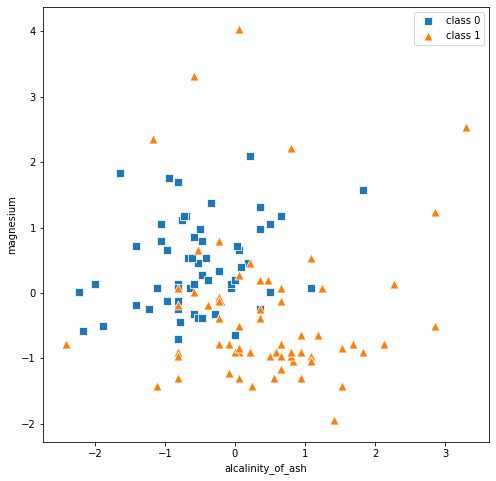

In [5]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.scatterplot(X[y==0,0],X[y==0,1],label='class 0',marker='s',s=80);
sns.scatterplot(X[y==1,0],X[y==1,1],label='class 1',marker='^',s=80);
plt.xlabel(features[0]); plt.ylabel(features[1]);

plt.savefig(IMAGEPATH+'wine_2class.png')

In [6]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3,metric='euclidean')
knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

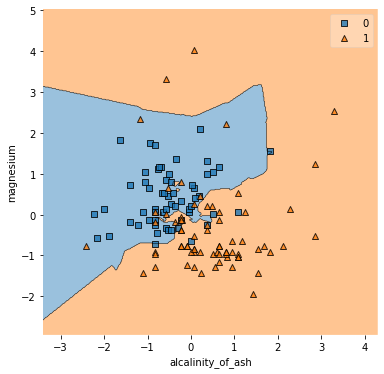

In [7]:
from mlxtend.plotting import plot_decision_regions
fig,ax = plt.subplots(1,1,figsize=(6,6))
plot_decision_regions(X, y, clf=knn);
plt.xlabel(features[0]); plt.ylabel(features[1]);

plt.savefig(IMAGEPATH+'wine_2class_knn.png')

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=.25, #default
                                                 stratify=y,
                                                 random_state=123)

In [9]:
X.shape, y.shape

((130, 2), (130,))

In [10]:
X_train.shape, X_test.shape

((97, 2), (33, 2))

In [11]:
y_train.shape, y_test.shape

((97,), (33,))

In [12]:
f'{X_test.shape[0]/X.shape[0]:0.2f}'

'0.25'

In [13]:
f'{ sum(y_train == 1) / len(y_train) :0.3f}'

'0.546'

In [14]:
from sklearn.dummy import DummyClassifier
dummy_cl = DummyClassifier(strategy='most_frequent')
dummy_cl.fit(X_train,y_train)
f'{ dummy_cl.score(X_test,y_test) :0.3f}'

'0.545'

In [15]:
knn.fit(X_train,y_train)
f'{ knn.score(X_test,y_test) :0.3f}'

'0.758'

In [16]:
k1 = KNeighborsClassifier(n_neighbors=1).fit(X_train,y_train)

In [17]:
print(f'acc on train: {k1.score(X_train,y_train) :0.2f}')
print(f'acc on test:  {k1.score(X_test,y_test)   :0.2f}')

acc on train: 0.98
acc on test:  0.58


In [18]:
kX = KNeighborsClassifier(n_neighbors=len(X_train)).fit(X_train,y_train)

In [19]:
print(f'acc on train: {kX.score(X_train,y_train) :0.2f}')
print(f'acc on test:  {kX.score(X_test,y_test)   :0.2f}')

acc on train: 0.55
acc on test:  0.55


In [20]:
KNeighborsClassifier(n_neighbors=len(X_train)).fit(X_train,y_train).score(X_test,y_test)

0.5454545454545454

In [21]:
from sklearn.model_selection import cross_val_score

In [22]:
# using accuracy
scores = cross_val_score(KNeighborsClassifier(n_neighbors=3),
                         X_train,
                         y_train,
                         cv=5)
scores

array([0.85      , 0.8       , 0.68421053, 0.78947368, 0.94736842])

In [23]:
print(f'{np.mean(scores) :0.2f} +- {2*np.std(scores) :0.2f}')

0.81 +- 0.17


In [24]:
mean_scores = []
for k in [1, 2, 3, 5, 10]:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn,X_train,y_train,cv=10,scoring='accuracy')
    mean_scores.append( (k,scores.mean()) )

In [25]:
mean_scores

[(1, 0.7655555555555557),
 (2, 0.7855555555555556),
 (3, 0.8166666666666668),
 (5, 0.7966666666666666),
 (10, 0.7866666666666667)]

In [26]:
# find the k that gives highest accuracy
sorted(mean_scores,key=lambda x:x[1])[-1]

(3, 0.8166666666666668)

In [27]:
from sklearn.model_selection import validation_curve
k = [1,2,3,5,10,20,50,80]
train_scores,test_scores = validation_curve(KNeighborsClassifier(),
                                            X_train, y_train,
                                            'n_neighbors',
                                            k,
                                            cv=10,
                                            scoring='accuracy'
                                           )
mean_train_scores = np.mean(train_scores,1)
mean_test_scores = np.mean(test_scores,1)

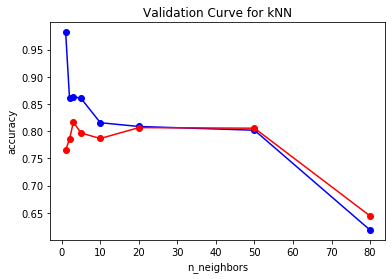

In [28]:
plt.plot(k, mean_train_scores, 'o-', color='b',label='training score');
plt.plot(k, mean_test_scores, 'o-', color='r', label='validation score');
plt.xlabel('n_neighbors'), plt.ylabel('accuracy');
plt.title('Validation Curve for kNN');
#plt.hlines(.5,0,14,ls=':'); plt.legend(loc='best);

plt.savefig(IMAGEPATH+'validation_curve.png')

In [29]:
len(X_train) - len(X_train)/10

87.3

In [30]:
from sklearn.model_selection import GridSearchCV

In [31]:
params = {'n_neighbors':[1,2,3,5,10,20,50],
          'metric':['euclidean','manhattan']}

gscv = GridSearchCV(KNeighborsClassifier(),params,cv=3,
                    scoring='accuracy')
gscv.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 5, 10, 20, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [32]:
gscv.best_params_

{'metric': 'manhattan', 'n_neighbors': 20}

In [33]:
knn = gscv.best_estimator_

In [34]:
scores = cross_val_score(gscv.best_estimator_,X_train,y_train,cv=5,
                         scoring='accuracy')
print(f'{np.mean(scores):0.2f} +- {2*np.std(scores):0.2f}')

0.81 +- 0.18


In [35]:
from sklearn.model_selection import learning_curve

train_sizes,train_scores,test_scores = learning_curve(KNeighborsClassifier(n_neighbors=3),
                                                      X_train, y_train,
                                                      cv=3,
                                                      train_sizes=[0.1  , 0.325, 0.55 , 0.775, 1.],
                                                      scoring='accuracy'
                                                     )
mean_train_scores = np.mean(train_scores,1)
mean_test_scores = np.mean(test_scores,1)

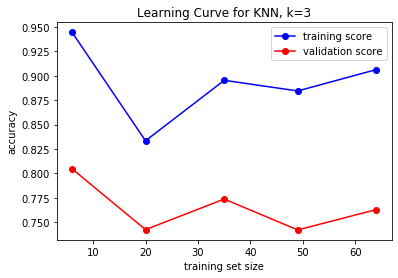

In [36]:
plt.plot(train_sizes, mean_train_scores, 'o-', color="b", label="training score");
plt.plot(train_sizes, mean_test_scores, 'o-', color="r", label="validation score")
plt.xlabel('training set size'), plt.ylabel('accuracy');
plt.title('Learning Curve for KNN, k=3');
plt.legend(loc="best");

plt.savefig(IMAGEPATH+'learning_curve.png')

In [37]:
# return predicted class probabilities
knn20 = KNeighborsClassifier(n_neighbors=20).fit(X_train,y_train)
y_pred = knn20.predict_proba(X_train) 
y_pred[:3,:]

array([[0.9, 0.1],
       [0. , 1. ],
       [0. , 1. ]])

In [38]:
tmp = np.transpose(np.vstack([y_pred[:,1],y_train]))

In [39]:
tmp = np.array(sorted(tmp,key=lambda x:x[0])[::-1])
tmp[:3],tmp[-3:]

(array([[1., 1.],
        [1., 1.],
        [1., 1.]]), array([[0.05, 0.  ],
        [0.05, 0.  ],
        [0.05, 0.  ]]))

In [40]:
# or just let sklearn do it
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:,1])

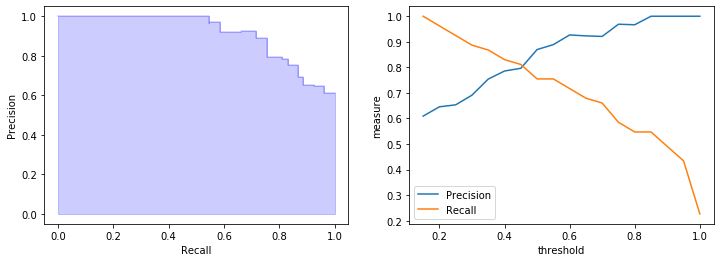

In [41]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].step(recall, precision, color='b', alpha=0.2, where='post');
ax[0].fill_between(recall, precision,color='b', step='post', alpha=0.2)
ax[0].set_xlabel('Recall');ax[0].set_ylabel('Precision');
ax[1].plot(thresholds,precision[:-1], label='Precision')
ax[1].plot(thresholds,recall[:-1],label='Recall')
ax[1].legend()
ax[1].set_xlabel('threshold');ax[1].set_ylabel('measure');

plt.savefig(IMAGEPATH+'precision_recall_curves.png')

In [42]:
scores = cross_val_score(knn20,X_train,y_train,cv=5,scoring='f1')
print(f'{np.mean(scores):0.2f} +- {2*np.std(scores):0.2f}')

0.80 +- 0.18


In [43]:
scores = cross_val_score(dummy_cl,X_train,y_train,cv=5,scoring='f1')
print(f'{np.mean(scores):0.2f} +- {2*np.std(scores):0.2f}')

0.71 +- 0.03


In [44]:
# again sklearn to the rescue
from sklearn.metrics import roc_curve
fpr_knn20, tpr_knn20, _ = roc_curve(y_train, y_pred[:,1])

In [45]:
def plot_roc(curves):
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    lw = 2
    for fpr,tpr,model_name in curves:
        l1, = ax.plot(fpr, tpr, lw=lw, label=model_name)
    ax.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_aspect('equal', 'box')
    ax.set_title('Receiver operating characteristic example')
    ax.legend()

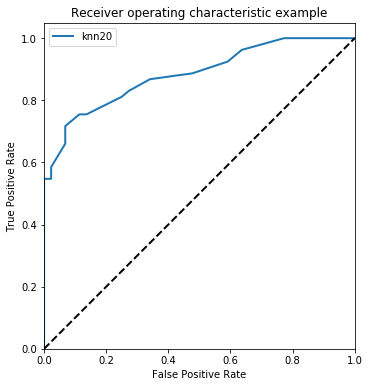

In [46]:
curves = [(fpr_knn20,tpr_knn20,'knn20')]
plot_roc(curves);

plt.savefig(IMAGEPATH+'roc_curve_01.png')

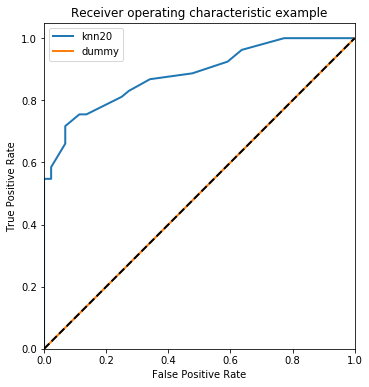

In [47]:
fpr_dummy, tpr_dummy, _ = roc_curve(y_train, dummy_cl.predict_proba(X_train)[:,1]) # Compare dummy
curves.append((fpr_dummy,tpr_dummy,'dummy')); plot_roc(curves);

plt.savefig(IMAGEPATH+'roc_curve_02.png')

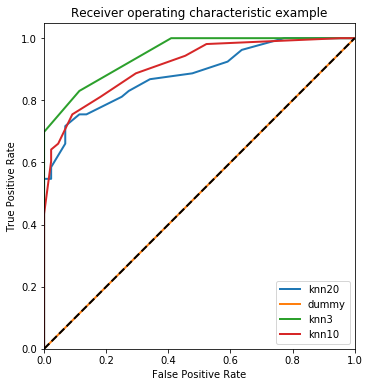

In [48]:
for k in [3,10]:
    fpr, tpr, _ = roc_curve(y_train,
                            KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train).predict_proba(X_train)[:,1])
    curves.append((fpr,tpr,'knn'+str(k)))
plot_roc(curves);

plt.savefig(IMAGEPATH+'roc_curve_03.png')

In [49]:
from sklearn.metrics import roc_auc_score

In [50]:
knn3 = KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)
for name,model in [('dummy',dummy_cl),('knn20',knn20),('knn3',knn3)]:
    y_pred = model.predict_proba(X_train)
    auc = roc_auc_score(y_train,y_pred[:,1])
    print('{:5s} auc = {:0.3f}'.format(name,auc))

dummy auc = 0.500
knn20 auc = 0.883
knn3  auc = 0.948


In [51]:
f'{knn3.score(X_test,y_test) :0.2f}'

'0.76'

In [52]:
tips = sns.load_dataset('tips')
tips.shape

(244, 7)

In [53]:
tips.head(5)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [54]:
226-185

41